# What is linear regression?

Linear regression is a machine learning model, where the predicted output $y$ is a linear function of the input $x$. If $x$ is a scalar, it looks like this:

> $y = \theta_1 x_1 + \theta_0$

For multiple inputs (multivariate) the model can be generalized by assuming $X$ is the vector $[x_0,x_1,x_2 ... x_n]$ where $x_0=1$ is an artificial element to accomodate for $\theta_0$:

> $y = \theta_0 x_0 + \theta_1 x_1 +  ...  + \theta_n x_n$ , where $x_0 = 1$
> 
> $y = \theta^T X$


The task then is to find the optimal vector $\theta$ with respect to a loss function (usually MSE, but sum of residuals/MAE can be used as well). Let's create a sample univariate (x is scalar) dataset to illustrate.

38.69892342562922


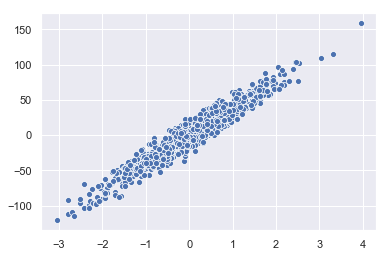

In [1]:
%matplotlib inline
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.linear_model import LinearRegression

X, y, coef = make_regression(n_samples=1000, n_features=1, n_informative=1, noise=10, random_state=1, coef=True)
ax = sns.scatterplot(x=X[:,0], y=y)
print(coef)

# How to find the best parameters $\theta$ ?

There are two ways:

* A "closed-form" *normal equation*
* An iterative approach (e.g. *gradient descent*)

But before we dive into details, we have to specify the cost function with respect to which we are seeking to optimize $\theta$.

> $J(\theta) = \frac{1}{2m} \sum\limits_{i=1}^m ( \hat{y}(x^{(i)}) - y^{(i)})^2$, where $\hat{y}$ is the predicted value.

This expression is also called the mean squared error (**MSE**) or L2 loss.

## Normal equation
This is an analytical (non-iterative) method. The optimal values of $\theta$ will be found in one pass:

> $\theta=(X^TX)^{−1}X^Ty$

Pros: 
* No iterations, faster
* No hyperparameter tuning (e.g. learning rate)

Cons:
* Data may not fit into memory
* $X^TX$ may be degenerate (non-invertible) e.g.:
  * redundant features (linear dependence) -> get rid of one of them
  * too many features/less data -> delete features, get more data, regularization
  * Use pseudo inverse to avoid this in general
* Won't scale to big number of features $n$ (inverting a matrix is $O(n^3)$. Use GD if $n > 10k$

### Pseudo inverse


Pseudo inverse $X^+$ can be used instead of normal inverse in order to handle the case when $X^T X$ is non-invertible. From the definition of pseudo inverse:

> $(X^T X)^{+} X^T = X^+$


Then the simplified normal equation looks like this:

> $\theta = X^{+}y $



Let's solve it with numpy using both inverse and pseudo inverse to see if we get the same solution.

[1] https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html

[2] http://spartanideas.msu.edu/2015/10/21/regression-via-pseudoinverse/


Inv:    [ 0.2905003  38.47831608]
Pinv:   [ 0.2905003  38.47831608]
Scikit: [0.2905002991350156, array([38.47831608])]


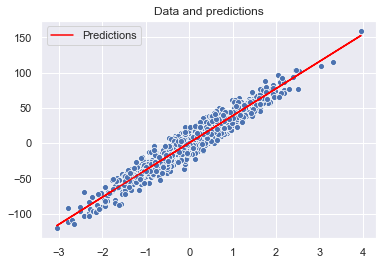

In [2]:
x1 = X[:,0]
x0 = np.ones(x1.shape)
x = np.column_stack( (x0,x1))
x_t = np.transpose(x)

# using inverse
theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(x_t,x)),x_t),y)
print('Inv:   ',theta)

# using pseudo inverse
theta_pinv = np.matmul(np.linalg.pinv(x),y)
print('Pinv:  ',theta_pinv)

# using scikit learn (again closed form)
reg = LinearRegression().fit(X, y)
print('Scikit:',[reg.intercept_,reg.coef_])

y_hat = np.matmul(x,theta)

ax = sns.scatterplot(x=x1, y=y)
h, = ax.plot(x1, y_hat, label="Predictions", color="red")
ax.set_title("Data and predictions")
legend = plt.legend(handles=[h])

Both inverse and pseudo inverse yield the same (good) result.

## Gradient descent
Linear regression can be solved iteratively with gradient descent (GD). Let's recap some of the advantages of GD:

* Can handle big datasets that don't fit in memory
* Scales better to a big number of features (e.g. $n > 10k$)
* We can use different loss functions (e.g. samples fit within an allowed tolerance around the linear model)
* Reuse our knowledge: GD can be applied to many other problems, such as neural nets.

GD can be implemented easily in frameworks that support automatic differentiation, such as tensorflow.

> Note: GD is sensitive to feature dimensions, so it might be a good idea to do feature normalization, to make it easier for GD to converge.

### Feature normalization
Normalization is appplied to each feature individually:

> $x_i = \frac{\displaystyle x_i - \mu}{\displaystyle \sigma}$

There are two things happening here:
* **Mean normalization**: Subtract mean and data becomes zero centered
* **Scaling**: Divide by range, std etc and data fits within some range (e.g. -1 to 1)

Here is a way to implement feature normalization with numpy:

In [3]:
u = np.mean(x1)
sigma = np.std(x1)
x1_norm = (x1 - u)/sigma
print(u,sigma)

0.038812476159601844 0.9810041339322116


In our case feature scaling is not necessary because $x_1$ seems already normalized (and also we have only one feature). Let's build a GD based linear regression model with tensorflow now:

In [4]:
import tensorflow as tf
tf.reset_default_graph()

batch_size = x.shape[0]
num_features = x.shape[1]
print('Batch size: {}, num_features:{}'.format(batch_size,num_features))

x_placeholder = tf.placeholder(tf.float32,shape=(None,num_features))
y_placeholder = tf.placeholder(tf.float32,shape=(None,1))

with tf.variable_scope('linear-regression'):
    theta_var = tf.get_variable('theta',shape=(num_features,1))
    y_predicted = tf.matmul(x_placeholder,theta_var)
    

print(y_predicted)
print(y_placeholder)
#loss = tf.losses.mean_squared_error(y_placeholder, y_predicted)
loss = tf.reduce_mean(tf.square(y_placeholder - y_predicted))

optimizer = tf.train.GradientDescentOptimizer(0.05)
train_step = optimizer.minimize(loss) # this will calculate gradients of loss and update all variables

writer = tf.summary.FileWriter('tensorboard')
writer.add_graph(tf.get_default_graph())

Batch size: 1000, num_features:2
Instructions for updating:
Colocations handled automatically by placer.
Tensor("linear-regression/MatMul:0", shape=(?, 1), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


Once the model, loss function and optimizer are defined we can proceed to training.

Theta:  [[ 0.2910892]
 [38.47653  ]]


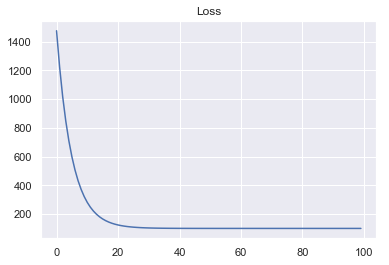

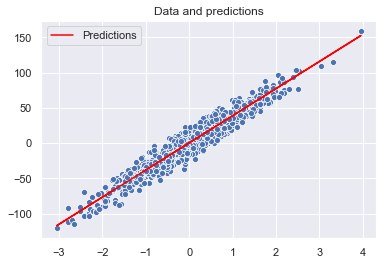

In [5]:
steps = 100
losses = []

y_reshaped = np.reshape(y,(len(y),1)) #needed to match the shape of y_predicted

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(steps):
        _,loss_val,y_predicted_val,theta_val = sess.run([train_step,loss,y_predicted,theta_var],
                                                        feed_dict={ x_placeholder:x, y_placeholder:y_reshaped  }) 
        losses.append(loss_val)

        
print('Theta: ', theta_val)

fig3,ax3 = plt.subplots()
h = ax3.plot(losses)
title = ax3.set_title("Loss")

fig4,ax4 = plt.subplots()
ax = sns.scatterplot(x=x1, y=y,ax=ax4)
h, = ax4.plot(x1, y_predicted_val, label="Predictions", color="red")
ax4.set_title("Data and predictions")
legend = plt.legend(handles=[h])

The result almost exactly matches the normal equation.

## Feature engineering

The idea is to replace one feature with another that (subjectively) better describes the input/output relation. E.g. use the area of a land plot instead of its width and height

## Non-linear (polynomial) regression

Expand the dataset inlcuding not only $x$ but e.g. $x^2 x^3, \sqrt{x}$ and then do a linear regression on the new data. This makes it possible to fit higher dimensional curves.

[ [1] Andrew Ng's lecture on Polynomial regression](https://www.youtube.com/watch?v=Hwj_9wMXDVo&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN&index=22)
